In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords
from nltk import stem
!pip install langdetect
from langdetect.detector_factory import DetectorFactory, PROFILES_DIRECTORY

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import os
import warnings
import logging
import time

import torch
!pip install torchinfo
from torchinfo import summary
from torch import nn
import torch.optim as optim
import torchtext
from torchmetrics import Recall, Accuracy, CohenKappa, AUROC, AveragePrecision, F1Score, Precision, ROC
from torch.utils.data import DataLoader, Dataset, TensorDataset

import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors
from gensim.matutils import unitvec

import xgboost as xgb

import tensorflow as tf
from tensorflow.python.keras import backend as K
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification

nltk.download('stopwords')
nltk.download('punkt')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993241 sha256=a752a387d1eaa3346426f9cb73fc195592ae01446ff6ebb20448a0db9998c693
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
categories = ['Utilities', 'Entertainment', 'Development', 'Communication', 'Management', 'Education', 'Design/Creativity']
path = '../input/tagged/tagged.csv'
df = pd.read_csv(path, sep='\t', index_col='id').dropna()#use gpu p100
df

,executable_name,browser_title,Category
id,,,
5140,chrome,[[Publication Title: software] OR [Publication...,Development
11754,chrome.exe,"номер, регистратура, запись, Городская поликли...",Utilities
11340,chrome.exe,И повсюду тлеют пожары / Little Fires Everywhe...,Entertainment
8554,chrome.exe,"Kiabi.ru, магазин одежды для женщин, мужчин, д...",Utilities
4390,chrome,IamMaxim/vigilant-palm-tree: Why Vigilant Palm...,Development
...,...,...,...
9295,chrome.exe,"Performance Testing Tutorial: What is, Types, ...",Development
855,Adobe Acrobat Reader DC,Introduction - Adobe Acrobat Reader DC,Utilities
9298,chrome.exe,Personal computing: personal computers and the...,Utilities


In [34]:
stop = stopwords.words('english') + stopwords.words('russian')

def get_factory_for():
    detector = DetectorFactory()
    profiles = []
    for lang in ['en', 'ru']:
        with open(os.path.join(PROFILES_DIRECTORY, lang), 'r', encoding='utf-8') as f:
            profiles.append(f.read())
    detector.load_json_profile(profiles)

    def _detect_langs(text):
        d = detector.create()
        d.append(text)
        return d.get_probabilities()

    def _detect(text):
        d = detector.create()
        d.append(text)
        return d.detect()

    detector.detect_langs = _detect_langs
    detector.detect = _detect
    return detector

stemmer_en = stem.SnowballStemmer('english')
stemmer_ru = stem.SnowballStemmer('russian')
language_detect = get_factory_for()
def stem_word(word: str) -> str:
    try:
        lang = language_detect.detect(word)
        if lang == 'ru':
            return stemmer_ru.stem(word)
        if lang == 'en':
            return stemmer_en.stem(word)
        return word
    except:
        return word

In [35]:
df = df.groupby('Category').head(600)
df['clean_title'] = df['browser_title'].str.replace("[^a-zA-ZА-Яа-я]", " ")
df['clean_title'] = df['clean_title'].apply(lambda x: x.lower())
df['clean_title'] = df['clean_title'].apply(lambda x: ' '.join([stem_word(word) for word in x.split() if word and word not in stop]))

df['Category'] = pd.Categorical(df['Category'])
df['Category_code'] = df['Category'].cat.codes
df

/tmp/ipykernel_31/3777287541.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_title'] = df['browser_title'].str.replace("[^a-zA-ZА-Яа-я]", " ")
/tmp/ipykernel_31/3777287541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_title'] = df['browser_title'].str.replace("[^a-zA-ZА-Яа-я]", " ")
/tmp/ipykernel_31/3777287541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_title'] = df['clean_title'].apply(lambda x: x.lower())
/t

,executable_name,browser_title,Category,clean_title,Category_code
id,,,,,
5140,chrome,[[Publication Title: software] OR [Publication...,Development,public titl softwar public titl programm publi...,2
11754,chrome.exe,"номер, регистратура, запись, Городская поликли...",Utilities,номер регистратур зап городск поликлиник казан...,6
11340,chrome.exe,И повсюду тлеют пожары / Little Fires Everywhe...,Entertainment,повсюд тлеют пожар littl fire everywher сезон ...,4
8554,chrome.exe,"Kiabi.ru, магазин одежды для женщин, мужчин, д...",Utilities,kiabi ru магазин одежд женщин мужчин дет малыш...,6
4390,chrome,IamMaxim/vigilant-palm-tree: Why Vigilant Palm...,Development,iammaxim vigil palm tree vigil palm tree well ...,2
...,...,...,...,...,...
9247,chrome.exe,Paper generation from Reports of Dragos на дос...,Management,paper generat report drago доск innometr trell...,5
9167,chrome.exe,Order Information - Kazan - Google Chrome,Management,order inform kazan googl chrome,5
9195,chrome.exe,Outlook Web App - Google Chrome,Communication,outlook web app googl chrome,0


In [36]:
# df = df.iloc[:10800]
df = df.iloc[:4600]

In [37]:
#train 80%, test 20%
X_train, X_test , y_train, y_test = train_test_split(df['clean_title'].values, df['Category_code'].values, train_size=0.8, random_state=0, stratify=df['Category_code'].values)

In [14]:
# list(api.info()['models'].keys())
wv: KeyedVectors = api.load('word2vec-google-news-300')

In [15]:
# sentences = [sentence.split() for sentence in X_train]
# wv = Word2Vec(sentences=sentences, workers=4)
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [wv[word] for word in words if word in wv]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)
# vstack
w2v_X_train = np.array([vectorize(sentence) for sentence in X_train])
w2v_X_test = np.array([vectorize(sentence) for sentence in X_test])
w2v_X_train.shape

(8640, 300)

In [16]:
scaler = MinMaxScaler()
w2v_X_train = scaler.fit_transform(w2v_X_train)
w2v_X_test = scaler.transform(w2v_X_test)

In [19]:
best_params_ = {'alpha': 1e-05, 'early_stopping': False, 'eta0': 0.001, 'learning_rate': 'constant', 'loss': 'hinge', 'penalty': 'l1', 'tol': 1e-05 }
classifiers = [RandomForestClassifier(), MultinomialNB(), SGDClassifier(**best_params_), LogisticRegression(), CalibratedClassifierCV(), KNeighborsClassifier(n_neighbors=7), xgb.XGBClassifier(max_depth=7, n_estimators=1000, objective='multi:softmax', num_class=7)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    for classifier in classifiers:
        classifier.fit(w2v_X_train, y_train)
        start = time.time()
        y_pred = classifier.predict(w2v_X_test)
        end = time.time()
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(classifier.__class__.__name__)
        print('Time', end - start)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1 score:', f1)
        print()

RandomForestClassifier
Time 0.06634664535522461
Precision: 0.6828984920459328
Recall: 0.6810185185185185
F1 score: 0.652042906753642

MultinomialNB
Time 0.003717660903930664
Precision: 0.4989553836806962
Recall: 0.5416666666666666
F1 score: 0.4949649966271794



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SGDClassifier
Time 0.002467632293701172
Precision: 0.6710882083707449
Recall: 0.6981481481481482
F1 score: 0.673346082576306

LogisticRegression
Time 0.0037009716033935547
Precision: 0.697853113548265
Recall: 0.6953703703703704
F1 score: 0.6766301638422039

CalibratedClassifierCV
Time 0.027207136154174805
Precision: 0.6969402274908526
Recall: 0.6990740740740741
F1 score: 0.6787753444566877

KNeighborsClassifier
Time 0.5324156284332275
Precision: 0.6939170849146519
Recall: 0.7018518518518518
F1 score: 0.6876638527232838

XGBClassifier
Time 0.490647554397583
Precision: 0.7114380627865545
Recall: 0.7129629629629629
F1 score: 0.6967253765814224



In [20]:
vectors = [TfidfVectorizer(binary=True), CountVectorizer()]
classifiers = [RandomForestClassifier(), MultinomialNB(), SGDClassifier(**best_params_), LogisticRegression(), CalibratedClassifierCV(), KNeighborsClassifier(n_neighbors=7), xgb.XGBClassifier(max_depth=7, n_estimators=1000, objective='multi:softmax', num_class=7)]
with warnings.catch_warnings():
    # best=0.7510869565217392
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    for vector in vectors:
        train_vectors = vector.fit_transform(X_train)
        test_vectors = vector.transform(X_test)
        for classifier in classifiers:
            classifier.fit(train_vectors, y_train)
            start = time.time()
            y_pred = classifier.predict(test_vectors)
            end = time.time()
            recall = recall_score(y_test, y_pred, average='weighted')
            precision = precision_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            print(classifier.__class__.__name__, vector.__class__.__name__)
            print('Time:', end - start)
            print('Precision:', precision)
            print('Recall:', recall)
            print('F1 score:', f1)
            print()

RandomForestClassifier TfidfVectorizer
Time 0.1490187644958496
Precision: 0.7589440935556387
Recall: 0.7481481481481481
F1 score: 0.7397962666297813

MultinomialNB TfidfVectorizer
Time 0.0004487037658691406
Precision: 0.6743345111029294
Recall: 0.7125
F1 score: 0.6676111410420221



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SGDClassifier TfidfVectorizer
Time 0.0007524490356445312
Precision: 0.7784892459535881
Recall: 0.7791666666666667
F1 score: 0.773645781413662

LogisticRegression TfidfVectorizer
Time 0.0010638236999511719
Precision: 0.7630652655102271
Recall: 0.7564814814814815
F1 score: 0.7437709027893161

CalibratedClassifierCV TfidfVectorizer
Time 0.0073394775390625
Precision: 0.7785835186146984
Recall: 0.7773148148148148
F1 score: 0.7733758912369901

KNeighborsClassifier TfidfVectorizer
Time 1.5381991863250732
Precision: 0.7344223587707626
Recall: 0.7277777777777777
F1 score: 0.7162089659708198

XGBClassifier TfidfVectorizer
Time 1.366805076599121
Precision: 0.7585217765778175
Recall: 0.7560185185185185
F1 score: 0.7513502997922651

RandomForestClassifier CountVectorizer
Time 0.18744134902954102
Precision: 0.7712864068681755
Recall: 0.7574074074074074
F1 score: 0.7502256809187248

MultinomialNB CountVectorizer
Time 0.0006325244903564453
Precision: 0.7530610035491059
Recall: 0.7379629629629629
F1 sc

In [38]:
sent_tokens = [nltk.tokenize.word_tokenize(t) for t in df['clean_title']]
all_words = np.concatenate(sent_tokens)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_words)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_seq = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_seq = pad_sequences(X_test_seq, maxlen=maxlen)

EMBEDDING_DIM = 1000
VOCAB_SIZE =  len(tokenizer.word_index) + 1

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

X_train_seq.shape

(2597, 100)

In [39]:
train_data = TensorDataset(torch.from_numpy(X_train_seq), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test_seq), torch.from_numpy(y_test))

BATCH_SIZE = 40

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [40]:
losses = []
def train(model,train_loader):
    model.train()
    for sentence, label in train_loader:
        model.zero_grad()
        
        tag_scores = model(sentence.to(device))
        label = label.type(torch.LongTensor).to(device)
        loss = loss_function(tag_scores, label)
        loss.backward()
        optimizer.step()

        
def test(model, valid_dl, i):
    model.eval()
    with torch.no_grad():
        settings = {"task": 'multiclass', "average":'weighted', "num_classes": 7}
        model_metrics = [
            Accuracy(**settings),
            Recall(**settings),
            Precision(**settings),
            F1Score(**settings)
        ]
        model_metrics = [model_metric.to(device) for model_metric in model_metrics]
        start = time.time()
        for x, y in valid_dl:
            
            y_hat = model(x.to(device))
            y = y.type(torch.LongTensor).to(device)
            loss = loss_function(y_hat, y)
            pred = torch.max(y_hat, 1)[1]
            for model_metric in model_metrics:
                model_metric(pred, y)
        end = time.time()
        model_metrics = [100 * model_metric.compute().item() for model_metric in model_metrics]
        losses.append(model_metrics)
        print('{}: Accuracy-{:.1f}%, Recall-{:.1f}%, Precision-{:.1f}% F1Score-{:.1f}%'.format(i, *model_metrics))
        if epoch % 25 == 24:
            print('Time-{:.4f}'.format(end - start))

0: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
1: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
2: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
3: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
4: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
5: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
6: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
7: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
8: Accuracy-19.1%, Recall-19.1%, Precision-12.7% F1Score-7.0%
9: Accuracy-20.2%, Recall-20.2%, Precision-21.3% F1Score-8.9%
10: Accuracy-20.0%, Recall-20.0%, Precision-11.6% F1Score-8.5%
11: Accuracy-21.5%, Recall-21.5%, Precision-32.7% F1Score-10.9%
12: Accuracy-24.0%, Recall-24.0%, Precision-24.2% F1Score-14.0%
13: Accuracy-24.0%, Recall-24.0%, Precision-24.4% F1Score-14.0%
14: Accuracy-25.7%, Recall-25.7%, Precision-24.5% F1Score-15.6%
15: Accuracy-27.5%, Recall-27.5%, Precision-23.9% F1Score-17.3%
16: A

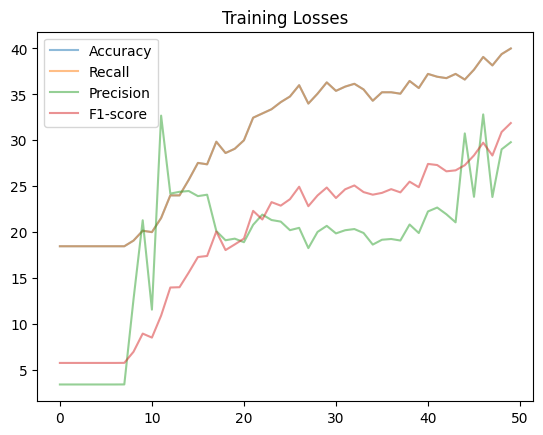

In [60]:
losses = []

class CNNModel(nn.Module):
    def __init__(self, embedding_dim ,vocab_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embedding_dim, embedding_dim // 2, kernel_size=2, padding=1)#padding='same'
        self.conv2 = nn.Conv1d(embedding_dim // 2, embedding_dim // 4, kernel_size=2, padding=1)
        self.conv3 = nn.Conv1d(embedding_dim // 4, embedding_dim // 8, kernel_size=2, padding=0)
        self.linear1 = nn.Linear(1500, 300)
        self.linear2 = nn.Linear(300, 7)
        self.dropout = nn.Dropout(0.2)
        self.pooling1 = nn.MaxPool1d(2)
        self.pooling2 = nn.MaxPool1d(2)
        self.pooling3 = nn.MaxPool1d(2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = x.reshape(len(x), self.embedding_dim, maxlen)
        x = self.relu(self.conv1(x))
        x = self.pooling1(x)
        x = self.relu(self.conv2(x))
        x = self.pooling2(x)
        x = self.relu(self.conv3(x))
        x = self.pooling3(x)
        
        x = self.dropout(x)
        x = x.reshape(len(x), -1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        return x
model = CNNModel(EMBEDDING_DIM, VOCAB_SIZE).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(50):  
    train(model,train_loader)
    test(model,test_loader, epoch)
fig, ax = plt.subplots()
plt.plot(range(len(losses)), [np.array(l[0]) for l in losses], label='Accuracy', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[1]) for l in losses], label='Recall', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[2]) for l in losses], label='Precision', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[3]) for l in losses], label='F1-score', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [45]:
PATH = './CNN.pt'
torch.save(model, PATH)
# .state_dict()

In [62]:
!ls

CNN.onnx  CNN.pt  CNN.pth  __notebook_source__.ipynb


In [61]:
x = next(iter(train_loader))[0].to(device)
# category = model(x)

input_names = ['Vectorized Sentence']
output_names = ['Category']
torch.onnx.export(model, x, 'CNN.onnx', input_names=input_names, output_names=output_names)

/tmp/ipykernel_31/3226681904.py:21: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  x = x.reshape(len(x), self.embedding_dim, maxlen)
/tmp/ipykernel_31/3226681904.py:30: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  x = x.reshape(len(x), -1)


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



0: Accuracy-30.6%, Recall-30.6%, Precision-18.1% F1Score-21.1%
1: Accuracy-32.0%, Recall-32.0%, Precision-17.5% F1Score-21.0%
2: Accuracy-32.2%, Recall-32.2%, Precision-18.1% F1Score-21.1%
3: Accuracy-33.2%, Recall-33.2%, Precision-24.2% F1Score-23.8%
4: Accuracy-34.5%, Recall-34.5%, Precision-34.9% F1Score-26.6%
5: Accuracy-35.5%, Recall-35.5%, Precision-34.2% F1Score-28.5%
6: Accuracy-38.8%, Recall-38.8%, Precision-37.8% F1Score-33.0%
7: Accuracy-39.5%, Recall-39.5%, Precision-36.8% F1Score-34.5%
8: Accuracy-38.3%, Recall-38.3%, Precision-38.7% F1Score-32.3%
9: Accuracy-43.5%, Recall-43.5%, Precision-39.0% F1Score-40.5%
10: Accuracy-39.5%, Recall-39.5%, Precision-36.1% F1Score-35.4%
11: Accuracy-43.5%, Recall-43.5%, Precision-38.3% F1Score-39.1%
12: Accuracy-42.9%, Recall-42.9%, Precision-40.3% F1Score-39.2%
13: Accuracy-47.1%, Recall-47.1%, Precision-45.4% F1Score-43.9%
14: Accuracy-46.3%, Recall-46.3%, Precision-46.0% F1Score-43.3%
15: Accuracy-49.7%, Recall-49.7%, Precision-48.3% 

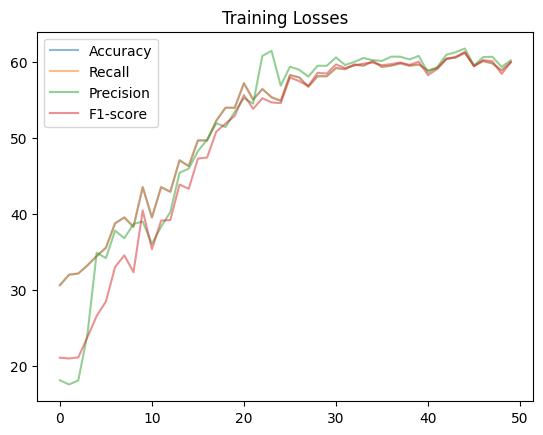

In [63]:
n_layers = 3

losses = []

class RNNModel(nn.Module):
    def __init__(self, embedding_dim ,vocab_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, embedding_dim // 4, batch_first=True, num_layers=n_layers)
        self.linear1 = nn.Linear(embedding_dim // 4, embedding_dim // 16)
        self.linear2 = nn.Linear(embedding_dim // 16, 7)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.embeddings(x)
        ht = torch.randn(n_layers, len(x), self.embedding_dim // 4).to(device)
        x, ht = self.rnn(x, ht)
        x = x[:, -1]
        x = self.dropout(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        return x
model = RNNModel(EMBEDDING_DIM, VOCAB_SIZE).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(50):  
    train(model,train_loader)
    test(model,test_loader, epoch)
fig, ax = plt.subplots()
plt.plot(range(len(losses)), [np.array(l[0]) for l in losses], label='Accuracy', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[1]) for l in losses], label='Recall', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[2]) for l in losses], label='Precision', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[3]) for l in losses], label='F1-score', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [64]:
x = next(iter(train_loader))[0].to(device)

input_names = ['Vectorized Sentence']
output_names = ['Category']
torch.onnx.export(model, x, 'RNN.onnx', input_names=input_names, output_names=output_names)

/tmp/ipykernel_31/2490000059.py:18: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  ht = torch.randn(n_layers, len(x), self.embedding_dim // 4).to(device)
/opt/conda/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4476: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



0: Accuracy-18.6%, Recall-18.6%, Precision-12.6% F1Score-6.1%
1: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
2: Accuracy-18.5%, Recall-18.5%, Precision-3.4% F1Score-5.8%
3: Accuracy-18.6%, Recall-18.6%, Precision-9.6% F1Score-6.1%
4: Accuracy-22.8%, Recall-22.8%, Precision-14.5% F1Score-12.8%
5: Accuracy-27.1%, Recall-27.1%, Precision-11.7% F1Score-15.5%
6: Accuracy-23.1%, Recall-23.1%, Precision-8.8% F1Score-12.7%
7: Accuracy-22.0%, Recall-22.0%, Precision-8.0% F1Score-11.7%
8: Accuracy-22.3%, Recall-22.3%, Precision-12.6% F1Score-12.9%
9: Accuracy-25.1%, Recall-25.1%, Precision-13.5% F1Score-16.6%
10: Accuracy-28.6%, Recall-28.6%, Precision-13.6% F1Score-16.3%
11: Accuracy-28.8%, Recall-28.8%, Precision-16.9% F1Score-15.9%
12: Accuracy-29.1%, Recall-29.1%, Precision-20.3% F1Score-16.1%
13: Accuracy-29.2%, Recall-29.2%, Precision-20.4% F1Score-16.3%
14: Accuracy-29.1%, Recall-29.1%, Precision-11.2% F1Score-15.9%
15: Accuracy-29.2%, Recall-29.2%, Precision-11.2% F1Score-1

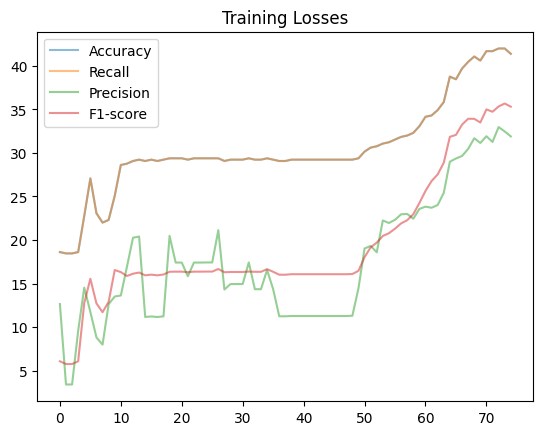

In [65]:
n_layers = 3

losses = []

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim ,vocab_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim // 4, batch_first=True, dropout=0, num_layers=n_layers)
        self.linear1 = nn.Linear(embedding_dim // 4, embedding_dim // 16)
        self.linear2 = nn.Linear(embedding_dim // 16, 7)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.embeddings(x)
        ht, ct = torch.randn(n_layers, len(x), self.embedding_dim // 4).to(device), torch.randn(n_layers, len(x), self.embedding_dim // 4).to(device)
        lstm_out, (ht, ct) = self.lstm(x, (ht, ct))
        x = lstm_out[:, -1]
        x = self.linear2(self.linear1(x))
#         x = self.relu(self.linear1(x))
#         x = self.relu(self.linear2(x))
        return x
model = LSTMModel(EMBEDDING_DIM, VOCAB_SIZE).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(75):  
    train(model,train_loader)
    test(model,test_loader, epoch)
fig, ax = plt.subplots()
plt.plot(range(len(losses)), [np.array(l[0]) for l in losses], label='Accuracy', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[1]) for l in losses], label='Recall', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[2]) for l in losses], label='Precision', alpha=0.5)
plt.plot(range(len(losses)), [np.array(l[3]) for l in losses], label='F1-score', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [66]:
x = next(iter(train_loader))[0].to(device)

input_names = ['Vectorized Sentence']
output_names = ['Category']
torch.onnx.export(model, x, 'LSTM.onnx', input_names=input_names, output_names=output_names)

/tmp/ipykernel_31/799271722.py:18: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  ht, ct = torch.randn(n_layers, len(x), self.embedding_dim // 4).to(device), torch.randn(n_layers, len(x), self.embedding_dim // 4).to(device)
/opt/conda/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4476: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [12]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} )
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [13]:
name = 'bert-base-multilingual-cased'
# name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(name, do_lower_case=True)

def mask_bert(texts: list[str], max_len: int):
    input_ids = []
    attention_masks = []
    i = 0
    for text in texts:
        encoded_dict = tokenizer.encode_plus(text, add_special_tokens = True, max_length=max_len, pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        i += 1
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    return input_ids, attention_masks

train_inp, train_mask = mask_bert(X_train, max_len=100)
test_inp, test_mask = mask_bert(X_test, max_len=100)
train_y = tf.convert_to_tensor(y_train)
test_y = tf.convert_to_tensor(y_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(name, num_labels=7)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./bert_model.h5', save_weights_only=True, monitor='val_accuracy', mode='min', save_best_only=True),
    tf.keras.callbacks.TensorBoard('./')]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=1e-4)
# 0.7792
bert_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = bert_model.fit([train_inp, train_mask], train_y, batch_size=BATCH_SIZE, epochs=10, validation_data=([test_inp, test_mask], test_y), callbacks=callbacks)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
216/216 [==============================] - 124s 494ms/step - loss: 1.7634 - accuracy: 0.3774 - val_loss: 1.6134 - val_accuracy: 0.4236
Epoch 2/10
216/216 [==============================] - 107s 495ms/step - loss: 1.5216 - accuracy: 0.4131 - val_loss: 1.4156 - val_accuracy: 0.4014
Epoch 3/10
216/216 [==============================] - 102s 475ms/step - loss: 1.4003 - accuracy: 0.4211 - val_loss: 1.3640 - val_accuracy: 0.4032
Epoch 4/10
216/216 [==============================] - 102s 474ms/step - loss: 1.3672 - accuracy: 0.4231 - val_loss: 1.3524 - val_accuracy: 0.4227
Epoch 5/10
216/216 [==============================] - 105s 486ms/step - loss: 1.3555 - accuracy: 0.4389 - val_loss: 1.3443 - val_accuracy: 0.4468
Epoch 6/10
 41/216 [====>.........................] - ETA: 1:16 - loss: 1.3821 - accuracy: 0.4476

In [17]:
start = time.time()
bert_model.predict([test_inp, test_mask], batch_size=BATCH_SIZE)
end = time.time()
end - start

54/54 [==============================] - 8s 143ms/step


10.278269290924072